# Chapter 5 - Some examples of data analysis

In [1]:
using Pkg
using Logging
using DynamicPPL, Turing
using Zygote, ReverseDiff
using StatsPlots, Random
using LaTeXStrings
using CSV
using DataFrames
using SpecialFunctions
using LinearAlgebra
using FillArrays
using CSV, DataFrames

In [2]:
Random.seed!(6)

TaskLocalRNG()

In [3]:
format=:png

:png

## 5.1 Pearson correlation

$$ \mu_{1},\mu_{2} \sim \text{Gaussian}(0, 1/ \sqrt{.001})  $$
$$ \sigma_{1},\sigma_{2} \sim \text{InvSqrtGamma} (.001, .001)  $$
$$ r \sim \text{Uniform} (-1, 1) $$  
$$ x_{i} \sim \text{MvGaussian} \left( (\mu_{1},\mu_{2}), \begin{bmatrix}\sigma_{1}^2 & r\sigma_{1}\sigma_{2}\\r\sigma_{1}\sigma_{2} & \sigma_{2}^2\end{bmatrix} \right)  $$

In [4]:
x = [[0.8, 102.0], 
     [1.0, 98.0], 
     [0.5, 100.0], 
     [0.9, 105.0], 
     [0.7, 103.0], 
     [0.4, 110.0],
     [1.2, 99.0], 
     [1.4, 87.0], 
     [0.6, 113.0], 
     [1.1, 89.0], 
     [1.3, 93.0]]

m = transpose(reduce(hcat, x));
freq_correlation = cor(m[:, 1], m[:, 2])

@model function PearsonCorrelationModel1(x)
    r ~ Uniform(-1., 1.)
    mu ~ filldist(Normal(0.0, 1. / sqrt(0.001)), 2)
    lambda ~ filldist(truncated(Gamma(0.001, 1 / 0.001), 
            lower=1e-7, upper=1000), 2)
    sigma = 1 ./ sqrt.(lambda)
    cov = [1/lambda[1]         r*sigma[1]*sigma[2]; 
           r*sigma[1]*sigma[2] 1/lambda[2]]
    for i in eachindex(x)
        x[i] ~ MultivariateNormal(mu, cov)
    end
end

PearsonCorrelationModel1 (generic function with 2 methods)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


Freq Correlation:-0.8109670756358504
Posterior R Estimation:-0.6949106643379455


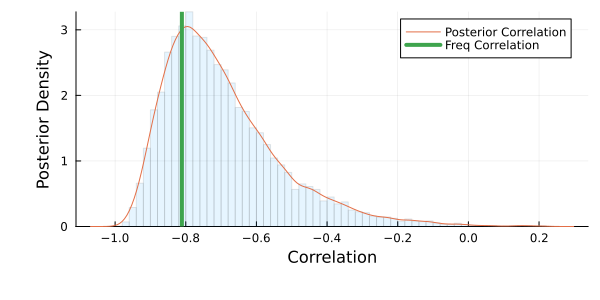

In [5]:
iterations = 10_000
burnin = 500
chain = sample(PearsonCorrelationModel1(x), NUTS(1000, 0.9; init_ϵ=0.02),
    iterations, burnin=burnin, init_theta=(r=-0.7, mu=[0.9, 100], lambda=[9, 0.02]))

bayes_corr_plot = histogram(chain[:r],
    label=false, alpha=0.1, normalize=true,
    bottom_margin=10Plots.mm, left_margin=10Plots.mm)
height = max(filter(e -> !(isnan(e)), bayes_corr_plot[1][1][:y])...)
density!(chain[:r], label="Posterior Correlation", size=(600, 300))
println("Freq Correlation:", freq_correlation)
println("Posterior R Estimation:", mean(chain[:r] |> collect))
plot!([freq_correlation, freq_correlation], [0, height],
    label="Freq Correlation", linewidth=4, fmt=format)
ylabel!("Posterior Density")
xlabel!("Correlation")

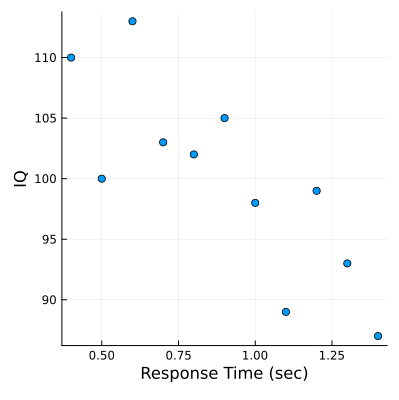

In [6]:
s = scatter(m[:, 1], m[:, 2], 
    size=(400, 400), fmt=format, legends=false)
ylabel!("IQ")
xlabel!("Response Time (sec)")

In [7]:
chain[[:r]]

Chains MCMC chain (10000×1×1 Array{Float64, 3}):

Iterations        = 1001:1:11000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 10.2 seconds
Compute duration  = 10.2 seconds
parameters        = r
internals         = 

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

           r   -0.6949    0.1667    0.0023   4831.4149   5796.8470    0.9999   ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           r   -0.9148   -0.8141   -0.7305   -0.6141   -0.2717


## 5.2 Pearson correlation with uncertainty

  
$$ \mu_{1},\mu_{2} \sim \text{Gaussian}(0, .001)  $$
$$ \sigma_{1},\sigma_{2} \sim \text{InvSqrtGamma} (.001, .001)  $$
$$ r \sim \text{Uniform} (-1, 1) $$  
$$ y_{i} \sim \text{MvGaussian} \left( (\mu_{1},\mu_{2}), \begin{bmatrix}\sigma_{1}^2 & r\sigma_{1}\sigma_{2}\\r\sigma_{1}\sigma_{2} & \sigma_{2}^2\end{bmatrix} \right)  $$
$$ x_{ij} \sim \text{Gaussian}(y_{ij},\lambda_{j}^e) $$  

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:17


Freq Correlation:-0.8109670756358504
Posterior R Estimation:-0.7046405795772329


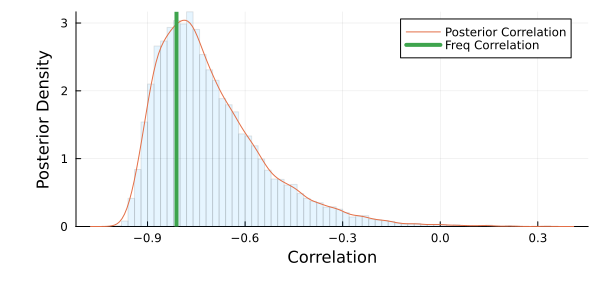

In [8]:
x = [[0.8, 102.0],
    [1.0, 98.0],
    [0.5, 100.0],
    [0.9, 105.0],
    [0.7, 103.0],
    [0.4, 110.0],
    [1.2, 99.0],
    [1.4, 87.0],
    [0.6, 113.0],
    [1.1, 89.0],
    [1.3, 93.0]]
sigma_error = [0.03, 1.0]
# sigma_error = [0.03, 10.0]

m = transpose(reduce(hcat, x));
freq_correlation = cor(m[:, 1], m[:, 2])

@model function PearsonCorrelationModel2(x)
    r ~ Uniform(-1.0, 1.0)
    mu ~ filldist(Normal(0.0, 1.0 / sqrt(0.001)), 2)
    lambda ~ filldist(truncated(Gamma(0.001, 1 / 0.001), lower=1e-7, upper=1000), 2)
    sigma = 1 ./ sqrt.(lambda)
    cov = [1/lambda[1] r*sigma[1]*sigma[2]
        r*sigma[1]*sigma[2] 1/lambda[2]]

    y = Vector{Vector}(undef, length(x))
    for i in eachindex(x)
        y[i] ~ MultivariateNormal(mu, cov)
        x[i] ~ MvNormal(y[i], sigma_error)
    end
end

iterations = 10_000
burnin = 5_000

logger = Logging.SimpleLogger(Logging.Error)
chain = Logging.with_logger(logger) do
    sample(PearsonCorrelationModel2(x), NUTS(1000, 0.9; init_ϵ=0.02), iterations, burnin=burnin)
end

bayes_corr_plot = histogram(chain[:r], label=false,
    alpha=0.1, normalize=true,
    bottom_margin=10Plots.mm, left_margin=10Plots.mm)
height = max(filter(e -> !(isnan(e)), bayes_corr_plot[1][1][:y])...)
density!(chain[:r], label="Posterior Correlation", size=(600, 300))
println("Freq Correlation:", freq_correlation)
println("Posterior R Estimation:", mean(chain[:r] |> collect))
plot!([freq_correlation, freq_correlation], [0, height],
    label="Freq Correlation", linewidth=4, fmt=format)
ylabel!("Posterior Density")
xlabel!("Correlation")

In [9]:
chain[[:r]]

Chains MCMC chain (10000×1×1 Array{Float64, 3}):

Iterations        = 1001:1:11000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 23.95 seconds
Compute duration  = 23.95 seconds
parameters        = r
internals         = 

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

           r   -0.7046    0.1678    0.0021   5990.7599   6210.5556    1.0001   ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           r   -0.9221   -0.8249   -0.7430   -0.6230   -0.2820


## 5.3 The kappa coefficient of agreement
$$ \kappa = (\xi-\psi)/(1-\psi)  $$
$$ \xi = \alpha\beta + (1-\alpha) \gamma  $$
$$ \psi = (\pi_{a}+\pi_{b})(\pi_{a}+\pi_{c})+(\pi_{b}+\pi_{d})(\pi_{c}+\pi_{d})  $$
$$ \alpha,\beta,\gamma \sim \text{Beta} (1, 1) $$  
$$ \pi_{a} = \alpha\beta  $$ 
$$ \pi_{b} = \alpha(1-\beta)  $$  
$$ \pi_{c} = (1-\alpha)(1-\gamma)  $$  
$$ \pi_{d} = (1-\alpha)\gamma  $$  
$$ x \sim \text{Multinomial} ([\pi_{a},\pi_{b},\pi_{c},\pi_{d}],n)  $$

In [10]:
# Influenza
x = [14, 4, 5, 210]

# Hearing Loss
# x = [20, 7, 103, 417]
# Rare Disease
# x = [0, 0, 13, 157]

@model function KappaCoefficientAgreement(x)
    alpha ~ Beta(1, 1)
    beta ~ Beta(1, 1)
    gamma ~ Beta(1, 1)

    pi1 = alpha * beta
    pi2 = alpha * (1 - beta)
    pi3 = (1 - alpha) * (1 - gamma)
    pi4 = (1 - alpha) * gamma

    xi = alpha * beta + (1 - alpha) * gamma

    x ~ Multinomial(sum(x), [pi1, pi2, pi3, pi4])

    psi = (pi1 + pi2) * (pi1 + pi3) + (pi2 + pi4) * (pi3 + pi4)
    kappa = (xi - psi) / (1 - psi)

    return (psi=psi, kappa=kappa)
end

iterations = 10_000
burnin = 5_000

model_kappa = KappaCoefficientAgreement(x)
chain = sample(model_kappa, NUTS(), iterations, burnin=burnin)
chains_params = Turing.MCMCChains.get_sections(chain, :parameters)
quantities = generated_quantities(model_kappa, chains_params);

┌ Info: Found initial step size
└   ϵ = 0.4
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


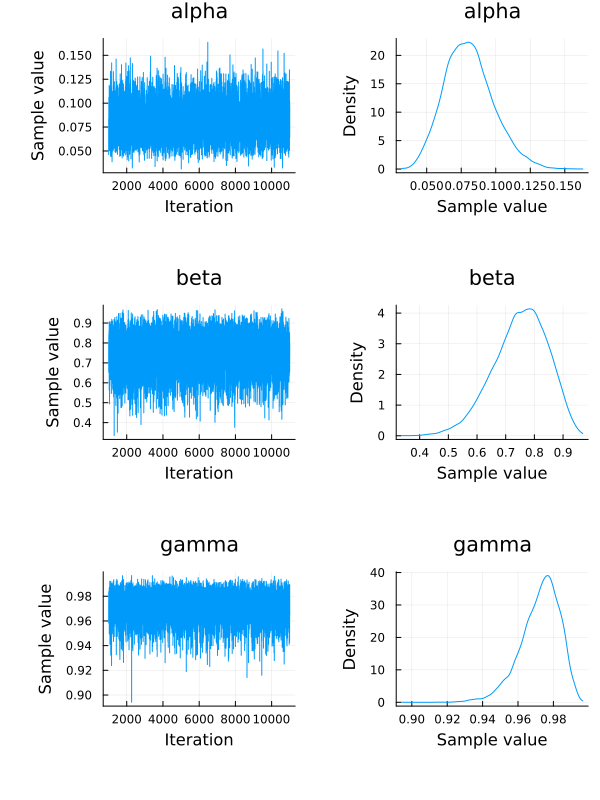

In [11]:
plot(chains_params, size=(600, 800), 
    left_margin=10Plots.mm, 
    bottom_margin=10Plots.mm, 
    fmt=format)

In [12]:
n = sum(x)
p0 = (x[1] + x[4]) / n
pe = (((x[1] + x[2]) * (x[1] + x[3])) + ((x[2] + x[4]) * (x[3] + x[4]))) / (n ^ 2)
kappa_cohen = (p0 - pe) / (1 - pe)

0.7357943807483934

Freq:0.7357943807483934
Mean Posterior:0.6976536297724409


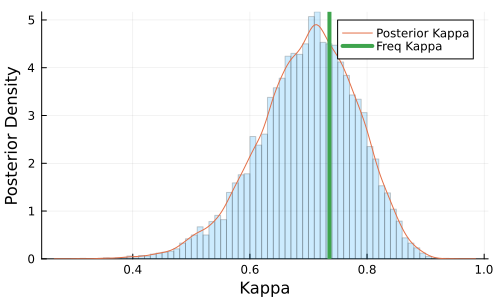

In [13]:
kappa = map(x -> x[:kappa], quantities)

h = histogram(kappa, size=(500, 300), alpha=0.2, normalize=true, label=false)
height = max(filter(e -> !(isnan(e)), h[1][1][:y])...)
density!(kappa, label="Posterior Kappa")

println("Freq:", kappa_cohen)
println("Mean Posterior:", mean(kappa))
plot!([kappa_cohen, kappa_cohen], [0, height],
    label="Freq Kappa", linewidth=4, fmt=format)
ylabel!("Posterior Density")
xlabel!("Kappa")

## 5.4 Change detection in time series data
  
Detecting a single change point in time series.

$$ \mu_{1},\mu_{2} \sim \text{Gaussian}(0, 1 / \sqrt{.001})  $$
$$ \lambda \sim \text{Gamma} (.001, .001)  $$
$$ \tau \sim \text{Uniform} (0, t_{max}) $$  
$$   c_{i} \sim
\begin{cases}
\text{Gaussian}(\mu_{1}, 1 / \lambda),  & \text{if $t_{i} \lt \tau$} \\
\text{Gaussian}(\mu_{2}, 1 / \lambda),  & \text{if $t_{i} \ge \tau$}
\end{cases}  $$

In [14]:
pwd()

"/Users/quangtiencs/quangtiencs_projects/bayesian-cognitive-modeling-with-turing.jl/ParameterEstimation/05. Some examples of data analysis"

In [15]:
df = DataFrame(CSV.File("changepointdata.csv"));

In [16]:
x = df.data
n = length(x)

@model function ChangePointTimeSeries(x, x_index)
    mu ~ MvNormal([0, 0], sqrt(1000) * ones(2))
    lambd ~ truncated(Gamma(0.001, 1 / 0.001), lower=1e-7, upper=1000)
    
    tau ~ Uniform(1, length(x))
    is_less_than_tau = x_index .< tau
    
    for i in eachindex(x)
        if is_less_than_tau[i] > 0
            x[i] ~ Normal(mu[1], 1/lambd)
        else
            x[i] ~ Normal(mu[2], 1/lambd)
        end
    end
end

iterations=2_000
burnin=1000

model_changepoint = ChangePointTimeSeries(x, eachindex(x) |> collect)
chain = sample(model_changepoint, NUTS(), iterations)

┌ Info: Found initial step size
└   ϵ = 1.220703125e-5
Sampling: 100%|█████████████████████████████████████████| Time: 0:01:17


Chains MCMC chain (2000×16×1 Array{Float64, 3}):

Iterations        = 1001:1:3000
Number of chains  = 1
Samples per chain = 2000
Wall duration     = 81.09 seconds
Compute duration  = 81.09 seconds
parameters        = mu[1], mu[2], lambd, tau
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters       mean       std      mcse    ess_bulk   ess_tail      rhat   ⋯
      Symbol    Float64   Float64   Float64     Float64    Float64   Float64   ⋯

       mu[1]    37.8917    0.2553    0.0146    305.1138   318.8511    1.0030   ⋯
       mu[2]    30.5651    0.3188    0.0092   1190.7706   928.9382    1.0018   ⋯
       lambd     0.1461    0.0032    0.0002    388.1012   457.9133    1.0001   ⋯
         tau   732.5951    2.7424    0.1756    387.7040   262.7940    1.0015   ⋯
                                               

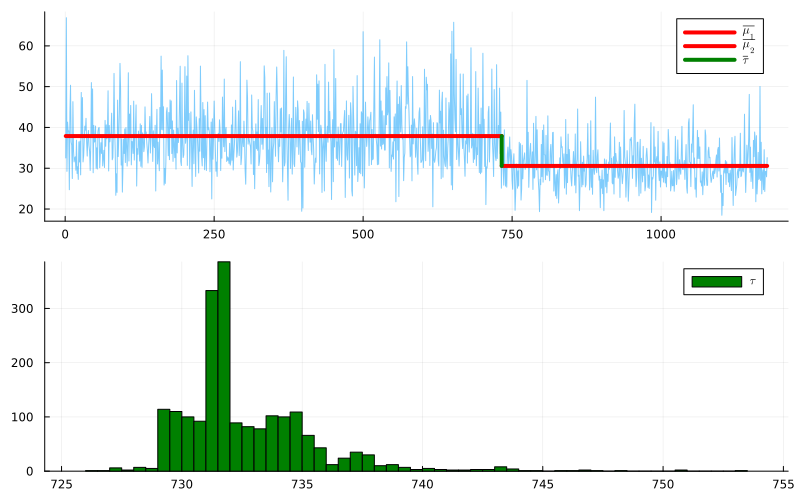

In [17]:
p1 = plot(eachindex(x) |> collect, x, size=(800, 300), label=false, alpha=0.5)
mu1 = mean(chain[:"mu[1]"])
mu2 = mean(chain[:"mu[2]"])
mean_tau = mean(chain[:tau])

plot!([1, mean_tau], [mu1, mu1], label=L"\overline{\mu_1}", linewidth=4, color="red")
plot!([mean_tau, length(x)], [mu2, mu2], label=L"\overline{\mu_2}", linewidth=4, color="red")
plot!([mean_tau, mean_tau], [mu1, mu2], label=L"\overline{\tau}", linewidth=4, color="green")

p2 = histogram(chain[:tau], size=(800, 300), label=L"\tau", color="green")
plot(p1, p2; layout=(2,1), size=(800, 500), fmt=format)

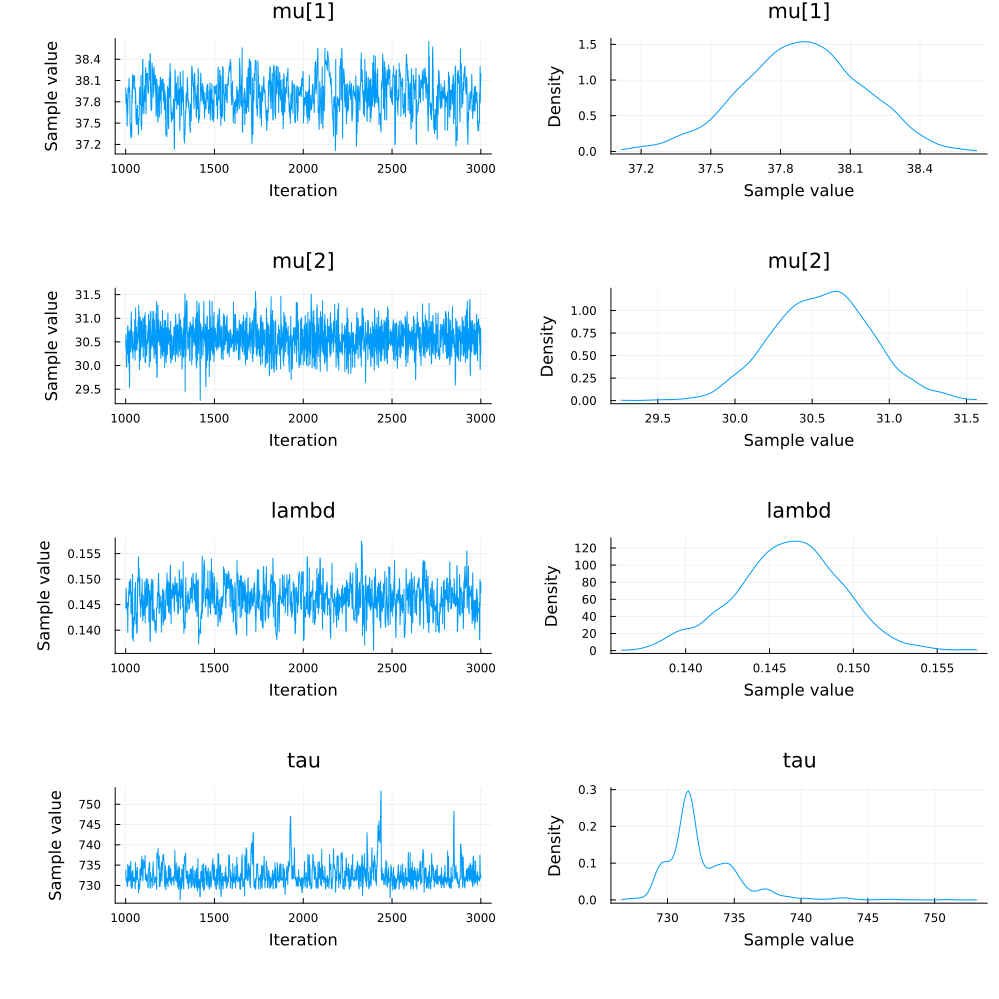

In [18]:
plot(chain, left_margin=10Plots.mm, bottom_margin=10Plots.mm, fmt=format)

## 5.5 Censored data

$$ \theta \sim \text{Uniform}(0.25, 1) $$
$$ z_{i} \sim \text{Binomial}(\theta, n) $$
$$ 15 \le z_{i} \le 25, \text{if} \; y_{i} = 1 $$ 


┌ Info: Found initial step size
└   ϵ = 0.0125
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


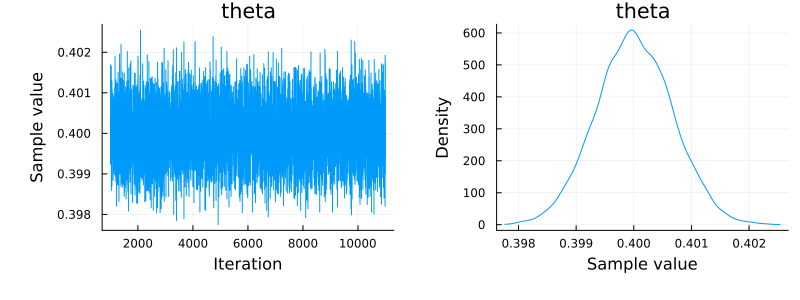

In [19]:
x = 30
n = 50
nfails = 949
range_unobs = 15:25 |> collect
z = 30

function censor_likelihood(n, p, range_unobs, nfails)
    return loglikelihood(Binomial(n, p), range_unobs) * nfails
end

@model function ChaSaSoon(x, n, range_unobs, nfails)
    theta ~ Uniform(0.25, 1.0)
    x ~ Binomial(n, theta)
    Turing.@addlogprob! censor_likelihood(n, theta, range_unobs, nfails)
end

iterations = 10_000
burnin = 1000

model_chachasoon = ChaSaSoon(x, n, range_unobs, nfails)
chain = sample(model_chachasoon, NUTS(), iterations, burnin=burnin)
plot(chain, size=(800, 300), left_margin=10Plots.mm, bottom_margin=10Plots.mm, fmt=format)

## 5.6 Recapturing planes

$$ k \sim \text{Hypergeometric}(n, x, t) $$ 
$$ t  \sim \text{Categorical}(\alpha) $$ 

In [20]:
x = 10  # number of captures
k = 4  # number of recaptures from n
n = 5  # size of second sample
tmax = 50  # maximum population size

lower = x + (n - k)
upper = tmax

bin_categorial = length(lower:upper)

@model function RecapturingPlanes(k)
    t ~ DiscreteUniform(lower, upper)
    k ~ Hypergeometric(x, t - x, n)
end

iterations = 10_000
burnin = 1000

recapturing_planes = RecapturingPlanes(k)
chain = sample(recapturing_planes, SMC(), iterations, burnin=burnin)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (10000×3×1 Array{Float64, 3}):

Log evidence      = -2.3067629385774087
Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 16.46 seconds
Compute duration  = 16.46 seconds
parameters        = t
internals         = lp, weight

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

           t   17.2438    6.7681    0.0905   3496.1426   2340.7392    1.0001   ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           t   11.0000   13.0000   15.0000   19.0000   38.0000


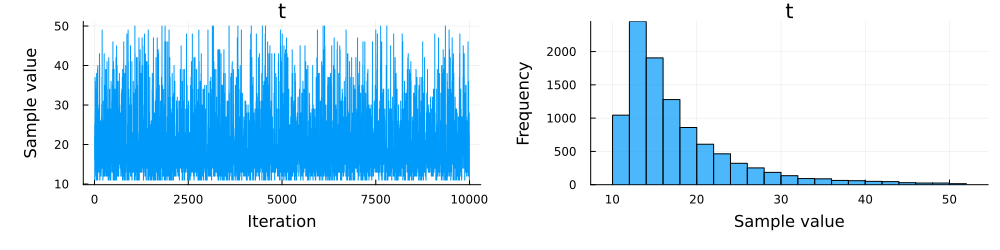

In [21]:
plot(chain, left_margin=10Plots.mm, bottom_margin=10Plots.mm, fmt=format)

In [22]:
Pkg.status()

Status `~/quangtiencs_projects/bayesian-cognitive-modeling-with-turing.jl/Project.toml`
  [336ed68f] CSV v0.10.11
  [a93c6f00] DataFrames v1.6.1
⌃ [366bfd00] DynamicPPL v0.23.0
  [7073ff75] IJulia v1.24.2
  [5ab0869b] KernelDensity v0.6.7
  [b964fa9f] LaTeXStrings v1.3.0
  [2ab3a3ac] LogExpFunctions v0.3.24
  [91a5bcdd] Plots v1.38.17
  [37e2e3b7] ReverseDiff v1.15.0
  [276daf66] SpecialFunctions v2.3.0
  [f3b207a7] StatsPlots v0.15.6
  [fce5fe82] Turing v0.28.1
  [e88e6eb3] Zygote v0.6.62
Info Packages marked with ⌃ have new versions available and may be upgradable.
